In [151]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import collections
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.spatial import distance

# k-means
from sklearn.cluster import KMeans

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno


In [152]:
#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def image_bin_adaptive(image_gs):
    image_bin = cv2.adaptiveThreshold(image_gs, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 10)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

In [153]:
#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]



In [154]:

# TODO 1 - Rotiranje regiona
def rotate_regions(contours,angles,centers,sizes):
    '''Funkcija koja vrši rotiranje regiona oko njihovih centralnih tačaka
    Args:
        contours: skup svih kontura [kontura1, kontura2, ..., konturaN]
        angles:   skup svih uglova nagiba kontura [nagib1, nagib2, ..., nagibN]
        centers:  skup svih centara minimalnih pravougaonika koji su opisani 
                  oko kontura [centar1, centar2, ..., centarN]
        sizes:    skup parova (height,width) koji predstavljaju duzine stranica minimalnog
                  pravougaonika koji je opisan oko konture [(h1,w1), (h2,w2), ...,(hN,wN)]
    Return:
        ret_val: rotirane konture'''
    ret_val = []
    for idx, contour in enumerate(contours):
                
        angle = angles[idx]
        cx,cy = centers[idx]
        height, width = sizes[idx]
        if width<height:
            angle+=90
            
        # Rotiranje svake tačke regiona oko centra rotacije
        alpha = np.pi/2 - abs(np.radians(angle))
        region_points_rotated = np.ndarray((len(contour), 2), dtype=np.int16)
        for i, point in enumerate(contour):
            x = point[0]
            y = point[1]
            
            #TODO 1 - izračunati koordinate tačke nakon rotacije
            rx = np.sin(alpha)*(x-cx) - np.cos(alpha)*(y-cy) + cx
            ry = np.cos(alpha)*(x-cx) + np.sin(alpha)*(y-cy) + cy
            
            
            region_points_rotated[i] = [rx,ry]
        ret_val.append(region_points_rotated)
        

    return ret_val

In [155]:
def merge_regions(contours):
    '''Funkcija koja vrši spajanje kukica i kvačica sa osnovnim karakterima
    Args:
        contours: skup svih kontura (kontura - niz tacaka bele boje)
    Return:
        ret_val: skup kontura sa spojenim kukicama i kvacicama'''
    ret_val = []
    merged_index = [] #lista indeksa kontura koje su već spojene sa nekim

    for i,contour1 in enumerate(contours): #slova
        if i in merged_index:
            continue
        min_x1 = min(contour1[:,0])
        max_x1 = max(contour1[:,0])
        min_y1 = min(contour1[:,1])
        max_y1 = max(contour1[:,1])
        for j,contour2 in enumerate(contours): #kukice
            if j in merged_index or i == j:
                continue
            min_x2 = min(contour2[:,0])
            max_x2 = max(contour2[:,0])
            min_y2 = min(contour2[:,1])
            max_y2 = max(contour2[:,1])
            
            #TODO 2 - izvršiti spajanje kukica iznad slova
            #spajanje dva niza je moguće obaviti funkcijom np.concatenate((contour1,contour2))
            
            if len(contour1)/2>len(contour2): #provera pretpostavke da je contour1 slovo
                
                if (min_y1-max_y2)<max(max_y1-min_y1,max_y2-min_y2)/2 \
                and (min_x2>min_x1-5 and max_x2<max_x1+5):
                    #spajanje kontura
                    ret_val.append(np.concatenate((contour1,contour2)))
                    merged_index.append(i)
                    merged_index.append(j)
            
                    
    #svi regioni koji se nisu ni sa kim spojili idu u listu kontura, bez spajanja
    for idx,contour in enumerate(contours):
        if idx not in merged_index:
            ret_val.append(contour)
        
    return ret_val

In [156]:
# TODO 3
def select_roi(image_orig, image_bin):
    
    img, contours_borders, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    contours = []
    contour_angles = []
    contour_centers = []
    contour_sizes = []
    for contour in contours_borders:
        center, size, angle = cv2.minAreaRect(contour)
        xt,yt,h,w = cv2.boundingRect(contour)

        region_points = []
        for i in range (xt,xt+h):
            for j in range(yt,yt+w):
                dist = cv2.pointPolygonTest(contour,(i,j),False)
                if dist>=0 and image_bin[j,i]==255: # da li se tacka nalazi unutar konture?
                    region_points.append([i,j])
        contour_centers.append(center)
        contour_angles.append(angle)
        contour_sizes.append(size)
        contours.append(region_points)
    
    #Postavljanje kontura u vertikalan polozaj
    contours = rotate_regions(contours, contour_angles, contour_centers, contour_sizes)
    
    #spajanje kukica i kvacica
    contours = merge_regions(contours)
    
    regions_dict = {}
    for contour in contours:
    
        min_x = min(contour[:,0])
        max_x = max(contour[:,0])
        min_y = min(contour[:,1])
        max_y = max(contour[:,1])

        region = np.zeros((max_y-min_y+1,max_x-min_x+1), dtype=np.int16)
        for point in contour:
            x = point[0]
            y = point[1]
            
             # TODO 3 - koordinate tacaka regiona prebaciti u relativne koordinate
            '''Pretpostavimo da gornja leva tačka regiona ima apsolutne koordinate (100,100).
            Ako uzmemo tačku sa koordinatama unutar regiona, recimo (105,105), nakon
            prebacivanja u relativne koordinate tačka bi trebala imati koorinate (5,5) unutar
            samog regiona.
            '''
            region[y-min_y,x-min_x] = 255

        
        regions_dict[min_x] = [resize_region(region), (min_x,min_y,max_x-min_x,max_y-min_y)]
        
    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    sorted_rectangles = sorted_regions[:,1]
    region_distances = [-sorted_rectangles[0][0]-sorted_rectangles[0][2]]
    for x,y,w,h in sorted_regions[1:-1, 1]:
        region_distances[-1] += x
        region_distances.append(-x-w)
    region_distances[-1] += sorted_rectangles[-1][0]
    
    return image_orig, sorted_regions[:, 0], region_distances
    #return image_orig, regions_dict.items(), region_distances



In [157]:
def create_ann():
    
    ann = Sequential()
    # Postavljanje slojeva neurona mreže 'ann'
    ann.add(Dense(input_dim=784, output_dim=128,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    ann.add(Dense(input_dim=128, output_dim=32,init="glorot_uniform"))
    ann.add(Activation("sigmoid"))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

In [196]:
def display_result(outputs, alphabet, k_means):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    # Odrediti indeks grupe koja odgovara rastojanju između reči, pomoću vrednosti iz k_means.cluster_centers_
    recnik_poz = ['Happy', 'happy', 'georgeus', 'funny', 'healthy', 'greatful', 'party', 'present', 'Thank', 'beautiful', 'gain', 'Marriage', 'polite', 'great', 'tuuuy', 'heppy',
                  'heemthy', 'greettumm', 'theuk', 'beeutatumm', 'geau', 'like', 'love', 'liked', 'loved', 'move', 'garmfraeud', 'Congratulations', 'congratulations',
                 'congrats', 'good', 'kiss', 'kisses', 'hug', 'hugs', 'kasses', 'hugsm', 'cougretumetaous', 'nice', 'hNppy', 'greNttumm', 'iove', 'girifrieud', 'cougretuietious']
    recnik_neg = ['worrying', 'loose', 'hurts', 'disappointed', 'crying', 'Death', 'broke', 'sad', 'ill', 'impolite', 'worst', 'misbehave', 'boring', 'hourt', 'huTs',
                  'houT', 'dksuppokuted', 'moose', 'oeeth', 'owaug', 'fight', 'fights', 'broken', 'horrible', 'dmSuppcmuted', 'huuS', 'hcuu', 'DeNth', 'oomug']
    reci = []
    recnik = []

    brojac_poz = 0
    brojac_neg = 0



    w_space_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]
    result = alphabet[winner(outputs[0])]

    for idx, output in enumerate(outputs[1:,:]):
        # Iterativno dodavati prepoznate elemente kao u vežbi 2, alphabet[winner(output)]
        # Dodati space karakter u slučaju da odgovarajuće rastojanje između dva slova odgovara razmaku između reči.
        # U ovu svrhu, koristiti atribut niz k_means.labels_ koji sadrži sortirana rastojanja između susednih slova.
        if (k_means.labels_[idx] != w_space_group):
            result += alphabet[winner(output)]

        else:
            reci.append(result)
            result = alphabet[winner(output)]



    for rec in reci:
        for rec2 in recnik_poz:
            if (rec == rec2):
                brojac_poz = brojac_poz+1

    for rec in reci:
        for rec2 in recnik_neg:
            if (rec == rec2):
                brojac_neg = brojac_neg+1

    return  brojac_poz, brojac_neg

In [160]:
def display_result2(outputs, alphabet, k_means):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    # Odrediti indeks grupe koja odgovara rastojanju između reči, pomoću vrednosti iz k_means.cluster_centers_
    w_space_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]
    result = alphabet[winner(outputs[0])]
    for idx, output in enumerate(outputs[1:,:]):
        # Iterativno dodavati prepoznate elemente kao u vežbi 2, alphabet[winner(output)]
        # Dodati space karakter u slučaju da odgovarajuće rastojanje između dva slova odgovara razmaku između reči.
        # U ovu svrhu, koristiti atribut niz k_means.labels_ koji sadrži sortirana rastojanja između susednih slova.
        if (k_means.labels_[idx] == w_space_group):
            result += ' '
        result += alphabet[winner(output)]
    return result

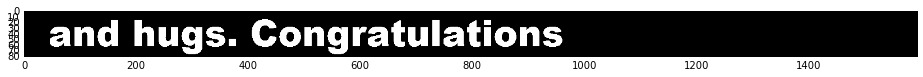

In [161]:
def remove_noise2(binary_image):
    ret_val = binary_image
    ret_val = invert(ret_val)
    return ret_val

def remove_noise(binary_image):
    ret_val = erode(dilate(erode(dilate(binary_image))))
    ret_val = invert(ret_val)
    return ret_val

img = load_image('slike/tekst7.jpg')
#img = image_bin(image_gray(img
image = remove_noise(image_bin(image_gray(img[370:450,:])))
display_image(image)

In [188]:
image_test_original_obucavanje = load_image('slike/alfabet.jpg')
#image_test_obucavanje = remove_noise(image_bin(image_gray(image_test_original_obucavanje)))

image_test_obucavanje = remove_noise(image_bin(image_gray(image_test_original_obucavanje)))

selected_test_obucavanje, letters_obucavanje, region_distances_obucavanje = select_roi(image_test_original_obucavanje.copy(), image_test_obucavanje)
region_distances_obucavanje = np.array(region_distances_obucavanje).reshape(len(region_distances_obucavanje), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_obucavanje)



inputs_obucavanje = prepare_for_ann(letters_obucavanje)

alphabet = ['a', 's', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'w', 'e', 'r', 't', 'y', 'u', 'i', 'o', 'p', 'x', 'c', 'v', 'b', 'n', 'm', 'I', 'T', 'S', 'A', 'L',
            '.', 'N', 'D']
#alphabet = ['a','s','d','f','g','h','j','k','l','č','ć','ž','š','p','o','i','u','z','t','r','e','c','v','b','n','m','đ']
#alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
#alphabet = ['A', 'S', 'D', 'F', 'G', 'H', 'J', 'K', 'L', 'Q', 'W', 'E', 'R', 'T', 'Y', 'U', 'I', 'O', 'P', 'Z', 'X', 'C', 'V', 'B', 'N', 'M']
outputs_obucavanje = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs_obucavanje, outputs_obucavanje)

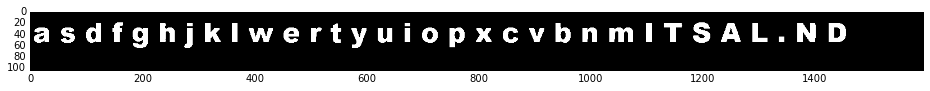

In [168]:
image_test_original = load_image('slike/alfabet.jpg')
image_test = remove_noise(image_bin(image_gray(image_test_original)))
display_image(image_test)

selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test)
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)

#sorted_regions_dict = collections.OrderedDict(sorted(letters_test))
#sorted_regions = np.array(sorted_regions_dict.values())
#konacno = sorted_regions[:, 0]

inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32))
#a,b = display_result(results_test, alphabet, k_means_test)
#if (a > 0):
#    print 'ovaj tekst je pozitivan'
#else:
#    print 'nista '''

#display_result2(results_test, alphabet, k_means_test)

ovaj tekst je pozitivan


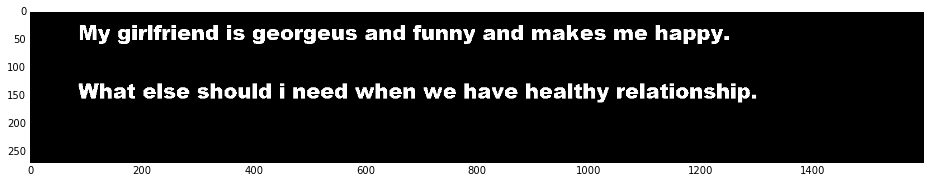

In [172]:
image_test_original = load_image('slike/tekst2.jpg')
image_test = remove_noise(image_bin(image_gray(image_test_original)))
display_image(image_test)

selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[0:100,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)

#sorted_regions_dict = collections.OrderedDict(sorted(letters_test))
#sorted_regions = np.array(sorted_regions_dict.values())
#konacno = sorted_regions[:, 0]

inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32)
                          )
a,b = display_result(results_test, alphabet, k_means_test)
#print display_result2(results_test, alphabet, k_means_test)


selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[100:200,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)
inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32))
c,d = display_result(results_test, alphabet, k_means_test)

a = a+c
b = b+d


if (a - b > 1 ):
    print 'ovaj tekst je pozitivan'
elif(b-a > 0):
    print 'ovaj tekst je negativan'
else: 
    print 'Ovaj tekst je neutralan'
    
    
    
#print display_result2(results_test, alphabet, k_means_test)

#print a
#print b


ovaj tekst je negativan
0
2


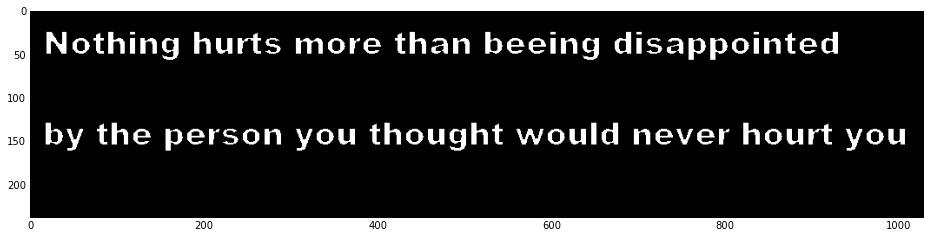

In [176]:

def remove_noise3(binary_image):
    ret_val = dilate(erode(dilate(binary_image)))
    ret_val = invert(ret_val)
    return ret_val


image_test_original = load_image('slike/tekst4.jpg')
image_test = remove_noise3(image_bin(image_gray(image_test_original)))
display_image(image_test)

selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[0:60,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)

#sorted_regions_dict = collections.OrderedDict(sorted(letters_test))
#sorted_regions = np.array(sorted_regions_dict.values())
#konacno = sorted_regions[:, 0]

inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32)
                          )
a,b = display_result(results_test, alphabet, k_means_test)
#print display_result2(results_test, alphabet, k_means_test)


selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[120:170,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)
inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32))
c,d = display_result(results_test, alphabet, k_means_test)

a = a+c
b = b+d


if (a - b > 2 ):
    print 'ovaj tekst je pozitivan'
elif(b-a > 0):
    print 'ovaj tekst je negativan'
else: 
    print 'Ovaj tekst je neutralan'
    
    
    
#print display_result2(results_test, alphabet, k_means_test)

print a
print b

Ovaj tekst je neutralan
1
0


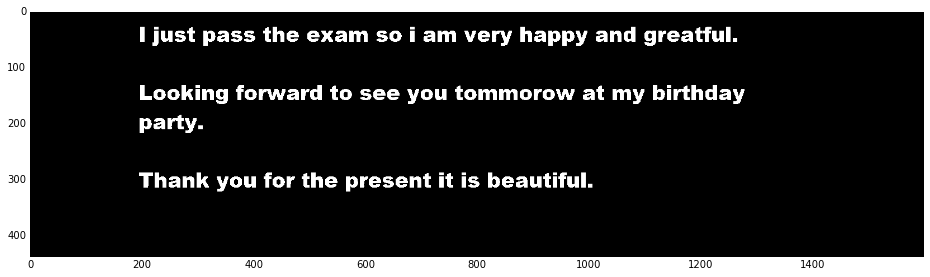

In [179]:
def remove_noise4(binary_image):
    ret_val = erode(dilate(binary_image))
    ret_val = invert(ret_val)
    return ret_val


image_test_original = load_image('slike/tekst1.jpg')
image_test = remove_noise4(image_bin(image_gray(image_test_original)))
display_image(image_test)

selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[0:100,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)

#sorted_regions_dict = collections.OrderedDict(sorted(letters_test))
#sorted_regions = np.array(sorted_regions_dict.values())
#konacno = sorted_regions[:, 0]

inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32)
                          )
a,b = display_result(results_test, alphabet, k_means_test)
#print display_result2(results_test, alphabet, k_means_test)


selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[120:180,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)
inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32))
c,d = display_result(results_test, alphabet, k_means_test)

#print display_result2(results_test, alphabet, k_means_test)

selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[180:220,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)
inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32))
e,f = display_result(results_test, alphabet, k_means_test)

#print display_result2(results_test, alphabet, k_means_test)

selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[260:330,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)
inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32))
g,h = display_result(results_test, alphabet, k_means_test)

#print display_result2(results_test, alphabet, k_means_test)


a = a+c+e+g
b = b+d+f+h


if (a - b > 2 ):
    print 'ovaj tekst je pozitivan'
elif(b-a > 0):
    print 'ovaj tekst je negativan'
else: 
    print 'Ovaj tekst je neutralan'
    
    
    


print a
print b

Ovaj tekst je neutralan
0
1


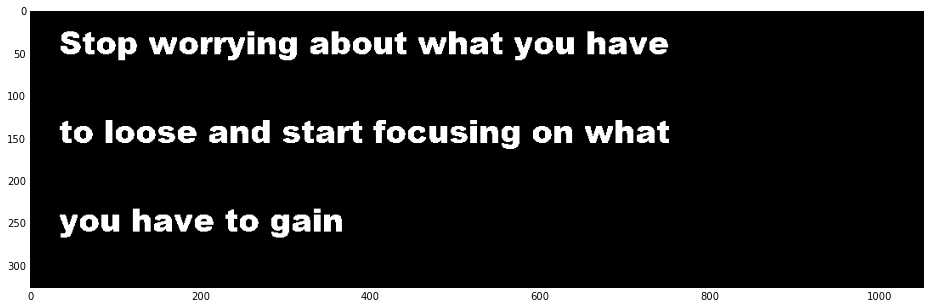

In [184]:
def remove_noise5(binary_image):
    ret_val = erode(dilate(erode(dilate((binary_image)))))
    ret_val = invert(ret_val)
    return ret_val


image_test_original = load_image('slike/teskt3.jpg')
image_test = remove_noise5(image_bin(image_gray(image_test_original)))
display_image(image_test)

selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[0:60,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)

#sorted_regions_dict = collections.OrderedDict(sorted(letters_test))
#sorted_regions = np.array(sorted_regions_dict.values())
#konacno = sorted_regions[:, 0]

inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32)
                          )
a,b = display_result(results_test, alphabet, k_means_test)
#print display_result2(results_test, alphabet, k_means_test)


selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[120:170,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)
inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32))
c,d = display_result(results_test, alphabet, k_means_test)

#print display_result2(results_test, alphabet, k_means_test)

selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[220:270,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)
inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32))
e,f = display_result(results_test, alphabet, k_means_test)

#print display_result2(results_test, alphabet, k_means_test)




a = a+c+e
b = b+d+f


if (a - b > 2 ):
    print 'ovaj tekst je pozitivan'
elif(b-a > 1):
    print 'ovaj tekst je negativan'
else: 
    print 'Ovaj tekst je neutralan'
    
    
    


print a
print b

Ovaj tekst je neutralan
0
1


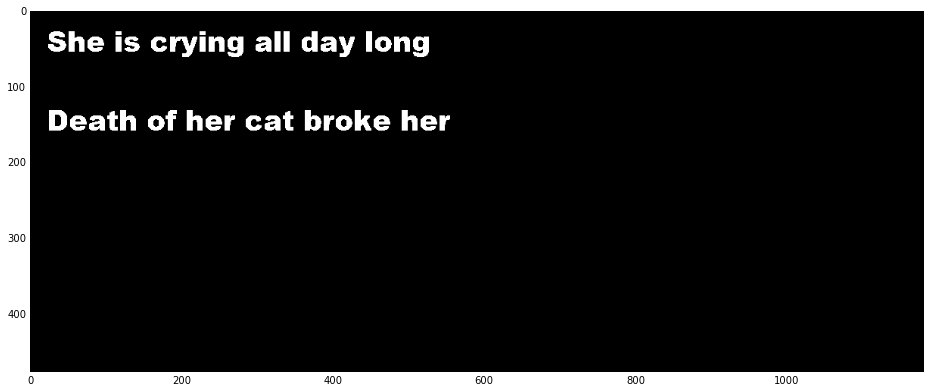

In [189]:
def remove_noise6(binary_image):
    ret_val = erode(dilate(erode(dilate((binary_image)))))
    ret_val = invert(ret_val)
    return ret_val


image_test_original = load_image('slike/tekst5.jpg')
image_test = remove_noise5(image_bin(image_gray(image_test_original)))
display_image(image_test)

selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[0:100,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)

#sorted_regions_dict = collections.OrderedDict(sorted(letters_test))
#sorted_regions = np.array(sorted_regions_dict.values())
#konacno = sorted_regions[:, 0]

inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32)
                          )
a,b = display_result(results_test, alphabet, k_means_test)
#print display_result2(results_test, alphabet, k_means_test)


selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[100:200,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)
inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32))
c,d = display_result(results_test, alphabet, k_means_test)

#print display_result2(results_test, alphabet, k_means_test)




a = a+c
b = b+d


if (a - b > 2 ):
    print 'ovaj tekst je pozitivan'
elif(b-a > 1):
    print 'ovaj tekst je negativan'
else: 
    print 'Ovaj tekst je neutralan'
    
    
    


print a
print b

ovaj tekst je pozitivan
2
0


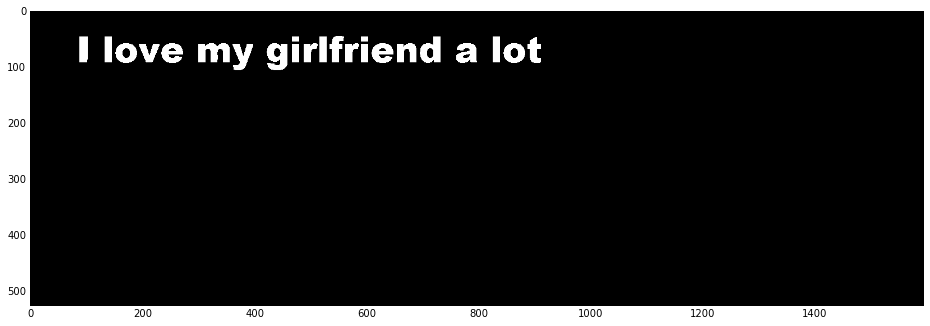

In [193]:
def remove_noise7(binary_image):
    ret_val = erode(dilate((binary_image)))
    ret_val = invert(ret_val)
    return ret_val


image_test_original = load_image('slike/tekst6.jpg')
image_test = remove_noise5(image_bin(image_gray(image_test_original)))
display_image(image_test)

selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[0:120,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)

#sorted_regions_dict = collections.OrderedDict(sorted(letters_test))
#sorted_regions = np.array(sorted_regions_dict.values())
#konacno = sorted_regions[:, 0]

inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32)
                          )
a,b = display_result(results_test, alphabet, k_means_test)
#print display_result2(results_test, alphabet, k_means_test)



a = a
b = b


if (a - b > 1 ):
    print 'ovaj tekst je pozitivan'
elif(b-a > 1):
    print 'ovaj tekst je negativan'
else: 
    print 'Ovaj tekst je neutralan'
    
    
    


print a
print b

ovaj tekst je pozitivan
2
0


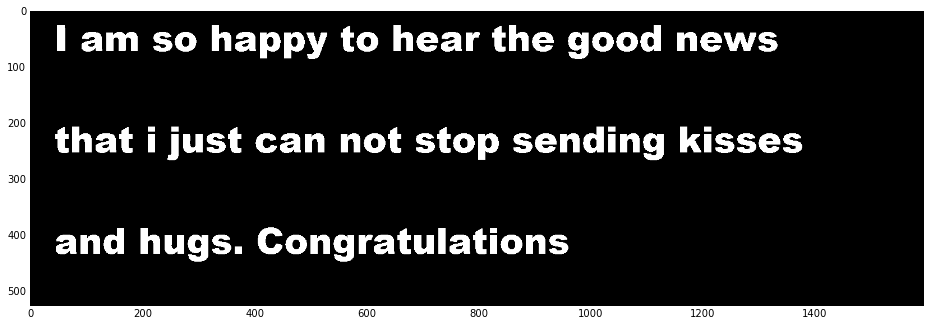

In [198]:
def remove_noise8(binary_image):
    ret_val = erode(dilate((binary_image)))
    ret_val = invert(ret_val)
    return ret_val


image_test_original = load_image('slike/tekst7.jpg')
image_test = remove_noise5(image_bin(image_gray(image_test_original)))
display_image(image_test)

selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[0:100,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)

#sorted_regions_dict = collections.OrderedDict(sorted(letters_test))
#sorted_regions = np.array(sorted_regions_dict.values())
#konacno = sorted_regions[:, 0]

inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32)
                          )
a,b = display_result(results_test, alphabet, k_means_test)
#print display_result2(results_test, alphabet, k_means_test)



selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[180:270,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)

#sorted_regions_dict = collections.OrderedDict(sorted(letters_test))
#sorted_regions = np.array(sorted_regions_dict.values())
#konacno = sorted_regions[:, 0]

inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32)
                          )
c,d = display_result(results_test, alphabet, k_means_test)
#print display_result2(results_test, alphabet, k_means_test)




selected_regions_test, letters_test, region_distances_test = select_roi(image_test_original.copy(), image_test[370:450,:])
region_distances_test = np.array(region_distances_test).reshape(len(region_distances_test), 1)
k_means_test = KMeans(n_clusters=2, max_iter=2000, tol=0.00001, n_init=10)
k_means_test.fit(region_distances_test)

#sorted_regions_dict = collections.OrderedDict(sorted(letters_test))
#sorted_regions = np.array(sorted_regions_dict.values())
#konacno = sorted_regions[:, 0]

inputs_test = prepare_for_ann(letters_test)
results_test = ann.predict(np.array(inputs_test, np.float32)
                          )
e,f = display_result(results_test, alphabet, k_means_test)
#print display_result2(results_test, alphabet, k_means_test)


a = a+c+e
b = b+d+f


if (a - b > 1 ):
    print 'ovaj tekst je pozitivan'
elif(b-a > 1):
    print 'ovaj tekst je negativan'
else: 
    print 'Ovaj tekst je neutralan'
    
    
    


print a
print b